### Determine gentrification labels

#### Author: Lauren Thomas
#### Created: 05/07/2021
#### Last updated: 05/07/2021

###### File description: This file determines the labels for which neighborhoods are gentrifying, which are eligible but do not gentrify, and were not eligible, using the following criteria:

###### Eligible to gentrify: 
###### - Housing sales prices/rent < 80% of median
###### - AND (any 3 of the following 4)
###### -- % low-income households > regional median
###### -- % college-educated (of population over 25 years of age) < regional median
###### -- % households that rent > regional median
###### -- % non-white (including Hispanics/Latinos) > regional median

###### Hot market:
###### - Change in median real rent > regional median OR
###### - Change in median real value for owner-occupied homes > regional median

###### Gentrification:
###### - Must begin as a vulnerable neighborhood (see above_
###### - Must have a 'hot market' (see above)
###### - Demographic changes between base & end years
###### --  % change in college-educated > regional median of % change in college-educated AND
###### -- % change in real median household income > regional median of % change

In [601]:
import os
import pickle

import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt

from os import sep

In [604]:
# Working directory
cwd = f"C:{sep}Users{sep}ltswe{sep}Dropbox{sep}Oxford{sep}Thesis"

# Data directory
data_dir = f'D:'

In [144]:
# Begin by importing data from IPUMS NGHIS (from the ACS)
# Import 2006-2010 (base year estimates) into pandas
est_0610_raw = pd.read_csv(f"{cwd}{sep}data{sep}2006_2010_estimates.csv", encoding = 'latin-1')

# Import 2014-2018 data estimates 
est_1418_raw = pd.read_csv(f"{cwd}{sep}data{sep}2014_2018_estimates.csv", encoding = 'latin-1')


In [457]:
# Get rid of data outside NYC 
est_0610 = est_0610_raw[(est_0610_raw['STATE'] == 'New York') & ((est_0610_raw['COUNTY'] == 'Bronx County') | 
                                              (est_0610_raw['COUNTY'] == 'New York County') |
                                              (est_0610_raw['COUNTY'] == 'Kings County') |
                                              (est_0610_raw['COUNTY'] == 'Queens County') |
                                              (est_0610_raw['COUNTY'] == 'Richmond County'))].reset_index(drop=True)

est_1418 = est_1418_raw[(est_1418_raw['STATE'] == 'New York') & ((est_1418_raw['COUNTY'] == 'Bronx County') | 
                                              (est_1418_raw['COUNTY'] == 'New York County') |
                                              (est_1418_raw['COUNTY'] == 'Kings County') |
                                              (est_1418_raw['COUNTY'] == 'Queens County') |
                                              (est_1418_raw['COUNTY'] == 'Richmond County'))].reset_index(drop=True)

In [458]:
# Calculate % of people with at least a bachelor's degree (of adults over 25 years of age)
est_0610["%_bachelors_0610"] = (est_0610["JN9E015"]+est_0610["JN9E016"]+est_0610["JN9E017"] \
                                 +est_0610["JN9E018"] +est_0610["JN9E032"]+est_0610["JN9E033"]+est_0610["JN9E034"] \
                                 + est_0610["JN9E035"])/est_0610["JN9E001"]
est_1418["%_bachelors_1418"] = (est_1418["AJYPE022"] + est_1418["AJYPE023"]+ est_1418["AJYPE024"]+ est_1418["AJYPE025"])/est_1418["AJYPE001"]

# Calc % of nonwhite (including Hispanic/Latino whites) for 06-10 
# = (total- (not hisp/latino & white alone))/total pop
est_0610["%_nonwhite_0610"] = (est_0610["JMJE001"] - est_0610["JMJE003"])/est_0610["JMJE001"] 

# Calc % that are renter households for 06-10 = # occupied by renters/total # of housing units
est_0610['%_hhrent_0610'] = est_0610["JRKE003"]/est_0610["JRKE001"]

# % of low-income households: % of households with income under $45k (see thesis notes for explanation of number)
est_0610['%_li_0610'] = (est_0610['JOHE002'] + est_0610['JOHE003'] + est_0610['JOHE004'] + est_0610['JOHE005'] \
                       + est_0610['JOHE006'] + est_0610['JOHE007'] + est_0610['JOHE008'] + est_0610['JOHE009'])/est_0610['JOHE001'] 

# Rename other relevant vars in both 2006-2010 and 2014-2018
est_0610 = est_0610.rename(columns={'JN9E001': '25plus_pop_0610','JOIE001':'med_hh_inc_0610_nom', 'JS5E001': 'med_rent_0610_nom', 'JTIE001': 'med_home_value_0610_nom'})
est_1418 = est_1418.rename(columns={'AJYPE001': '25plus_pop_1418', 'AJZAE001': 'med_hh_income_1418', 'AJ3EE001': 'med_rent_1418', 'AJ3QE001': 'med_home_value_1418'})

In [459]:
# Rent, home value, and median household income are both in 2010/2018 adjusted $$ -- so adjust 2010 to be in 2018 $$
est_0610["med_hh_income_0610"] = est_0610["med_hh_inc_0610_nom"].apply(lambda x: 1.15*x)
est_0610["med_rent_0610"] = est_0610["med_rent_0610_nom"].apply(lambda x: 1.15*x)
est_0610["med_home_value_0610"] = est_0610["med_home_value_0610_nom"].apply(lambda x: 1.15*x)

In [460]:
# Keep only vars of interest (above constructed terms plus REAL med hh income, median gross rent, median home value)
est_0610 = est_0610[["GISJOIN", "STATE", "COUNTY", '25plus_pop_0610', "%_bachelors_0610", '%_nonwhite_0610', '%_hhrent_0610',
                     '%_li_0610', "med_hh_income_0610", "med_rent_0610", 'med_home_value_0610']]
est_1418 = est_1418[["GISJOIN", "STATE", "COUNTY", '25plus_pop_1418',"%_bachelors_1418",
                     "med_hh_income_1418", "med_rent_1418", 'med_home_value_1418']]


In [481]:
# # Merge!
est_all = est_0610.merge(est_1418, on = ["GISJOIN", "STATE", "COUNTY"])   

# Drop census tracts with 0 population (53) and those where both median rent and median home value in 06-10 are missing (7)
# AND where both median rent and median home value in 14-18 are missing (3 after above deleted)
# AND where median household income in 2014-2018 is missing (4 after above are deleted)
est_all = est_all[(est_all['25plus_pop_1418'] != 0) & (est_all['25plus_pop_0610'] != 0) &
                 ((est_all['med_rent_0610'].isna()==False) | (est_all['med_home_value_0610'].isna()==False)) &
                  ((est_all['med_rent_1418'].isna()==False) | (est_all['med_home_value_1418'].isna()==False)) &
                 (est_all['med_hh_income_1418'].isna()==False)].reset_index(drop=True)



In [486]:
# Find medians over all census tracts of variables at base period (2006/2010) to determine which neighborhoods are 
# eligible to gentrify
med_bach_start = est_all["%_bachelors_0610"].median()
med_nw_start = est_all['%_nonwhite_0610'].median()
med_hhrent_start = est_all['%_hhrent_0610'].median()
med_rent_start = est_all["med_rent_0610"].median()
med_home_value_start = est_all['med_home_value_0610'].median()
med_li_start = est_all['%_li_0610'].median()

In [487]:
# Determine which neighborhoods are eligible to gentrify
# Firstly, must meet 3 of the following 4 non-housing (price/rent) criteria: % li-hh > med, % college-educated < med, % hh's rent > med, % nonwhite > med.
# Create Series from list comprehensions that correspond to 1 if criteria of census tract is met 0 if not and None if either var is NaN
li_0610_col = est_all.columns.get_loc('%_li_0610')
bachelors_0610_col = est_all.columns.get_loc('%_bachelors_0610')
hhrent_0610_col = est_all.columns.get_loc('%_hhrent_0610')
nonwhite_0610_col = est_all.columns.get_loc('%_nonwhite_0610')

# Note that est_all.shape[0] = number of tracts in est_all (all the tracts in NYC minus those with 0 pop)
# LI
li_0610 = pd.Series([1 if est_all.iloc[tract, li_0610_col] > med_li_start 
                else 0 if est_all.iloc[tract, li_0610_col] <= med_li_start 
                else None for tract in range(est_all.shape[0])])
# college-educated
bachelors_0610 = pd.Series([1 if est_all.iloc[tract, bachelors_0610_col] < med_bach_start 
                else 0 if est_all.iloc[tract, bachelors_0610_col] >= med_bach_start 
                else None for tract in range(est_all.shape[0])])

# % of households that rent
hhrent_0610 = pd.Series([1 if est_all.iloc[tract, hhrent_0610_col] > med_hhrent_start 
                else 0 if est_all.iloc[tract, hhrent_0610_col] <= med_hhrent_start 
                else None for tract in range(est_all.shape[0])])

# Non-white
nonwhite_0610 = pd.Series([1 if est_all.iloc[tract, nonwhite_0610_col] > med_nw_start 
                else 0 if est_all.iloc[tract, nonwhite_0610_col] <= med_nw_start 
                else None for tract in range(est_all.shape[0])])

# Now, create series = sum of each element in the above 
nonhousing_crit_0610 = pd.Series([li_0610[tract] + bachelors_0610[tract] + hhrent_0610[tract] + nonwhite_0610[tract]
                              for tract in range(est_all.shape[0])])
    

In [488]:
# Next, median rent or median home value must be < 80% of the NYC median (med_rent_start & med_home_value_start)
# Don't have to worry about NAs cuz we got rid of all of them already :D -- so everything is either 0 or 1!
rent_0610_col = est_all.columns.get_loc('med_rent_0610')
hv_0610_col = est_all.columns.get_loc('med_home_value_0610')

housing_crit_0610 = pd.Series([1 if est_all.iloc[tract, rent_0610_col] < 0.8*med_rent_start 
                               or est_all.iloc[tract, hv_0610_col] < 0.8*med_home_value_start
                              else 0 for tract in range(est_all.shape[0])])

# Finally, determine whether a neighbourhood is eligible to gentrify -- must have 1 on housing_crit and 3+ on nonhousing
est_all["eligible_gentrify"] = pd.Series([1 if housing_crit_0610[tract] == 1 and nonhousing_crit_0610[tract] >= 3 
                               else 0 for tract in range(est_all.shape[0])])

In [489]:
est_all['eligible_gentrify'].value_counts()

0    1695
1     405
Name: eligible_gentrify, dtype: int64

In [529]:
# Next up, determine whether a neighbourhood had a 'hot market' -- meaning % change in median real rent > nyc median change
# or % change in median home value > nyc median change 

# Find % change in median real rent & median home value change
est_all['change_rent'] = (est_all['med_rent_1418'] - est_all['med_rent_0610'])/est_all['med_rent_0610']
est_all['change_home_value'] = (est_all['med_home_value_1418'] - est_all['med_home_value_0610'])/est_all['med_home_value_0610']

# Drop census tracts where change_rent is NA & change_home_value is NA as well (1)
est_all = est_all[(est_all['change_rent'].isna() == False) | (est_all['change_home_value'].isna() == False)]

# Calculate median changes
med_change_rent, med_change_home_value = est_all['change_rent'].median(), est_all['change_home_value'].median()

# Col numbers for change rent and change home value
change_rent_col, change_hv_col = est_all.columns.get_loc('change_rent'), est_all.columns.get_loc('change_home_value')

# Determine 'hot market'
est_all['hot_market'] = [1 if est_all.iloc[tract, change_rent_col] > med_change_rent 
                        or est_all.iloc[tract, change_hv_col] > med_change_home_value
                        else 0 for tract in range(est_all.shape[0])]


In [543]:
# Finally, determine whether a neighbourhood has been gentrified
# Find change in % of college-educated residents & % change in real median hh income
est_all['change_college'] = est_all['%_bachelors_1418'] - est_all['%_bachelors_0610']
est_all['change_hh_inc'] = (est_all['med_hh_income_1418'] - est_all['med_hh_income_0610'])/est_all['med_hh_income_0610']

# Medians
med_change_college, med_change_hh_income = est_all['change_college'].median(), est_all['change_hh_inc'].median()

# Col numbers for eligible to gentrify, hot market, change in college-edu residents and change in hh income
elig_gentrify_col, hot_market_col = est_all.columns.get_loc('eligible_gentrify'), est_all.columns.get_loc('hot_market')
change_coll_col, change_hh_inc_col = est_all.columns.get_loc('change_college'), est_all.columns.get_loc('change_hh_inc')

# Neighbourhood gentrifies IF it is eligible to, it has a hot market, change_college > median and change_hh_inc > med
est_all['gentrification'] = [1 if est_all.iloc[tract, change_coll_col] > med_change_college 
                            and est_all.iloc[tract, change_hh_inc_col] > med_change_hh_income
                            and est_all.iloc[tract, elig_gentrify_col] == 1 
                            and est_all.iloc[tract, hot_market_col] == 1
                            else 0 for tract in range(est_all.shape[0])]

In [578]:
check = pd.Series([1 if est_all.iloc[tract, change_coll_col] > med_change_college 
                   and est_all.iloc[tract, change_hh_inc_col] > med_change_hh_income
                   and est_all.iloc[tract, hot_market_col] == 1
                   else 0 for tract in range(est_all.shape[0])])
check.value_counts()

0    1568
1     531
dtype: int64

In [557]:
# Make a more understandable fips code (11 digits instead of 13)
def gen_fips_from_gisjoin(x):
    ''' x = GISJOIN code '''
    # x[4:7] is county code, x[8:14] = census tract code ('36' is always state code)
    return "36" + x[4:7] + x[8:14]

est_all['fips_code'] = est_all['GISJOIN'].apply(lambda x: gen_fips_from_gisjoin(x))

In [560]:
# MAKE MAPS!

# Read in NYC Census Tract files
nycct = gp.read_file(f'{cwd}{sep}data{sep}shapefiles{sep}nyct2010.shp')

# Project shapefile into lat/long
nycct_proj = nycct.to_crs("epsg:4326")

# Generate full geoids (state FIPS + county FIPS + CT FIPS)
# NY State FIPS: 36
# County fips: 061 (Manhattan), 005 (Bronx), 081 (Queens), 085 (Staten Island), 047 (Brooklyn).
# BoroCT2010 uses a weird county code system where 1=Manhattan,2=Bronx,3=Brooklyn,4=Queens,& 5=SI
def gen_fips(x):
    ''' x = BoroCT2010 code'''
    county_code = x[0:1]
    ct_code = x[1:7]
    if county_code == '5': #SI
        return '36'+'085' + ct_code
    elif county_code == '1': #Manhattan
        return '36'+'061' + ct_code
    elif county_code == '4': #Queens
        return '36'+'081' + ct_code
    elif county_code == '3': #Brooklyn
        return '36'+'047' + ct_code
    else: #Bronx
        return '36'+'005' +ct_code

nycct_proj['fips_code'] = nycct_proj['BoroCT2010'].apply(lambda x: gen_fips(x))

In [566]:
# Right merge (keeping everything from nycct_proj) and create merged geopandas data frame
gentrify_gdf = gp.GeoDataFrame(est_all.merge(nycct_proj, on = 'fips_code', how='right'))

In [611]:
# Generate category = 1,2,3 where 1 = not eligible to gentrify, 2 = eligible to gentrify but didn't, 3 = gentrified
elig_gent_col, gent_col = gentrify_gdf.columns.get_loc('eligible_gentrify'), gentrify_gdf.columns.get_loc('gentrification')
gentrify_gdf['gentrification_category'] = [1 if gentrify_gdf.iloc[tract, elig_gent_col] == 0
                                          else 2 if gentrify_gdf.iloc[tract,gent_col] == 0
                                          else 3 if gentrify_gdf.iloc[tract,gent_col] == 1
                                          else None for tract in range(gentrify_gdf.shape[0])]

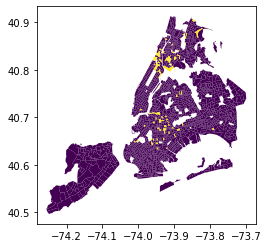

In [592]:
# Now, for the fun stuff! Create map of all gentrified 
gentrify_gdf.plot(column='gentrification')
plt.savefig(f"{cwd}{sep}figures{sep}gentrification.jpg")

In [568]:
gentrify_gdf.gentrification.value_counts()

0.0    2003
1.0      96
Name: gentrification, dtype: int64

In [619]:
# Reduce data down to just fips code, eligible_gentrify, gentrification label & geometry then pickle data for use in other
labels_gdf = gentrify_gdf[['fips_code', 'eligible_gentrify', 'gentrification', 'gentrification_category', 'geometry']]
labels_pickle = open(f'{data_dir}{sep}pickle{sep}labels_gdf.pickle', 'wb')
pickle.dump(labels_gdf, labels_pickle)